In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
from keras import callbacks, layers, models, mixed_precision
from sklearn.model_selection import train_test_split

policy = mixed_precision.Policy("mixed_float16")
mixed_precision.set_global_policy(policy)

sns.set(style="whitegrid")

In [2]:
class DropoutScheduler(callbacks.Callback):
    """
    Keras Callback to dynamically adjust the dropout rate.
    Implements strategies from the paper 'Dropout Reduces Underfitting'.
    Simplified version for dense networks (MLP).
    
    Args:
        mode (str): 'standard', 'early', or 'late'.
        switch_epoch (int): The epoch where the behavior switches.
        rate (float): The dropout rate to apply when active (e.g., 0.2).
        verbose (int): 1 to log changes, 0 for silence.
        
    Usage:
        dropout_scheduler = DropoutScheduler(mode='early', switch_epoch=15, rate=0.2, verbose=1)
        model.fit(X_train, y_train, epochs=50, callbacks=[dropout_scheduler])
    """
    def __init__(self, mode: str, switch_epoch: int, rate: float, verbose=0):
        super(DropoutScheduler, self).__init__()
        # Validate mode
        valid_modes = ['standard', 'early', 'late', 'none']
        if mode not in valid_modes:
            raise ValueError(f"Mode must be one of {valid_modes}")
        
        self.mode = mode
        self.switch_epoch = switch_epoch
        self.active_rate = rate
        self.verbose = verbose
        self.dropout_layers = []

    def on_train_begin(self, logs=None):
        # Recursively retrieve all Dropout layers
        self.dropout_layers = []
        for layer in self.model.layers:
            if isinstance(layer, layers.Dropout):
                self.dropout_layers.append(layer)
            if hasattr(layer, 'layers'):
                for sub_layer in layer.layers:
                    if isinstance(sub_layer, layers.Dropout):
                        self.dropout_layers.append(sub_layer)
        
        if self.verbose > 0:
            print(f"[DropoutScheduler] {len(self.dropout_layers)} Dropout layers tracked.")

    def on_epoch_begin(self, epoch, logs=None):
        new_rate = 0.0
        
        if self.mode == 'standard':
            new_rate = self.active_rate
        elif self.mode == 'none':
            new_rate = 0.0
        elif self.mode == 'early':
            # Active at start, then disabled after switch_epoch
            if epoch < self.switch_epoch:
                new_rate = self.active_rate
            else:
                new_rate = 0.0     
        elif self.mode == 'late':
            # Inactive at start, then active after switch_epoch
            if epoch < self.switch_epoch:
                new_rate = 0.0
            else:
                new_rate = self.active_rate

        # Apply rate
        for layer in self.dropout_layers:
            layer.rate = new_rate
            
        if self.verbose > 0 and epoch % 5 == 0:
            status = "ACTIVE" if new_rate > 0 else "INACTIVE"
            print(f"[Epoch {epoch+1}] Strategy '{self.mode}': {status} (rate={new_rate:.2f})")

## Model Functions

In [12]:
class ExperimentPipeline:
    """Pipeline to run experiments with different datasets and models.

    Args:
        dataset_name (str): 'mnist', 'cifar10', or 'cifar100'.
        model_type (str): 'dense' or 'cnn'.
        subset_fraction (float): Fraction of training data to use (0 < fraction <= 1.0).

    Usage:
        pipeline = ExperimentPipeline(dataset_name='mnist', model_type='dense', subset_fraction=0.5)
        history = pipeline.train(mode='early', switch_epoch=15, rate=0.2, epochs=50)
    """

    def __init__(
        self, dataset_name: str, model_type: str, subset_fraction: float = 1.0
    ) -> None:
        self.dataset_name = dataset_name
        self.model_type = model_type
        self.subset_fraction = subset_fraction
        self._load_data(dataset_name, subset_fraction)
        

        # Vérification de la détection du GPU
        gpus = tf.config.list_physical_devices("GPU")

        if gpus:
            print(f"✅ GPU detected : {len(gpus)} available(s)")
            for gpu in gpus:
                print(
                    f"   -> Name : {tf.config.experimental.get_device_details(gpu)['device_name']}"
                )
        else:
            print("⚠️ NO GPU DETECTED. The code will run slowly on CPU.")

        if model_type == "dense":
            self.model_factory = self._create_dense_model
        elif model_type == "cnn":
            self.model_factory = self._create_convolutional_model
        else:
            raise ValueError(f"Model type '{model_type}' non reconnu.")

        print(f"✅ Pipeline Ready: {dataset_name.upper()} | {model_type.upper()}")

    def _load_data(self, name: str, subset_fraction: float = 1.0) -> None:
        """Load dataset and prepare train/val splits.

        Args:
            name (str): Dataset name.
            subset_fraction (float): Fraction of training data to use.
        """
        if name == "mnist":
            (X_tr, y_tr), (X_te, y_te) = keras.datasets.mnist.load_data()
            X_tr = np.expand_dims(X_tr, -1).astype("float32") / 255.0
            X_te = np.expand_dims(X_te, -1).astype("float32") / 255.0
        elif name == "cifar10":
            (X_tr, y_tr), (X_te, y_te) = keras.datasets.cifar10.load_data()
            X_tr = X_tr.astype("float32") / 255.0
            X_te = X_te.astype("float32") / 255.0
        elif name == "cifar100":
            (X_tr, y_tr), (X_te, y_te) = keras.datasets.cifar100.load_data()
            X_tr = X_tr.astype("float32") / 255.0
            X_te = X_te.astype("float32") / 255.0
        else:
            raise ValueError("Dataset unknown")

        if subset_fraction < 1.0:
            subset_size = int(len(X_tr) * subset_fraction)
            X_tr = X_tr[:subset_size]
            y_tr = y_tr[:subset_size]
            print(
                f"⚠️ Using subset: {subset_fraction * 100:.1f}% of training data ({subset_size} samples)"
            )

        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            X_tr, y_tr, test_size=0.2, random_state=42
        )
        self.input_shape = self.X_train.shape[1:]
        self.num_classes = len(np.unique(self.y_train))

    def _create_dense_model(self, dropout_rate: float) -> models.Sequential:
        """Create a simple dense MLP model with dropout.

        Args:
            dropout_rate (float): Dropout rate to use in Dropout layers.

        Returns:
            models.Sequential: Compiled Keras model.
        """
        return models.Sequential(
            [
                layers.Input(shape=self.input_shape),
                layers.Flatten(),
                layers.Dense(256, activation="relu"),
                layers.Dropout(dropout_rate),
                layers.Dense(128, activation="relu"),
                layers.Dropout(dropout_rate),
                layers.Dense(64, activation="relu"),
                layers.Dropout(dropout_rate),
                layers.Dense(self.num_classes, activation="softmax"),
            ]
        )

    def _create_convolutional_model(self, dropout_rate: float) -> models.Sequential:
        """Create a simple CNN model with dropout.

        Args:
            dropout_rate (float): Dropout rate to use in Dropout layers.

        Returns:
            models.Sequential: Compiled Keras model.
        """
        return models.Sequential(
            [
                layers.Input(shape=self.input_shape),
                layers.Conv2D(32, 3, activation="relu", padding="same"),
                layers.Dropout(dropout_rate),
                layers.Conv2D(32, 3, activation="relu", padding="same"),
                layers.MaxPooling2D(2),
                layers.Dropout(dropout_rate),
                layers.Conv2D(64, 3, activation="relu", padding="same"),
                layers.Dropout(dropout_rate),
                layers.Flatten(),
                layers.Dense(64, activation="relu"),
                layers.Dropout(dropout_rate),
                layers.Dense(self.num_classes, activation="softmax"),
            ]
        )

    def train(
        self,
        mode: str,
        switch_epoch: int,
        rate: float,
        epochs: int,
        batch_size: int = 64,
        verbose: int = 0,
    ) -> keras.callbacks.History:
        """Train the model with specified dropout scheduling.

        Args:
            mode (str): 'standard', 'early', or 'late'.
            switch_epoch (int): Epoch to switch dropout behavior.
            rate (float): Dropout rate to use when active.
            epochs (int): Number of training epochs.
            batch_size (int): Batch size for training.
            verbose (int): Verbosity level for training output.

        Returns:
            keras.callbacks.History: Training history object.
        """
        keras.backend.clear_session()
        model = self.model_factory(dropout_rate=rate)
        model.compile(
            optimizer="adam",
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"],
        )
        scheduler = DropoutScheduler(
            mode=mode, switch_epoch=switch_epoch, rate=rate, verbose=verbose
        )
        return model.fit(
            self.X_train,
            self.y_train,
            validation_data=(self.X_val, self.y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[scheduler],
            verbose=verbose,
        )

    # --- COMPARISON PLOTS ---

    def compare_learning_curves(
        self,
        modes: list = ["standard", "early", "late"],
        switch_epoch: int = 10,
        rate: float = 0.3,
        epochs: int = 20,
    ) -> None:
        """Train multiple modes and plot them on the same graph.

        Args:
            modes (list): List of modes to compare.
            switch_epoch (int): Epoch to switch dropout behavior.
            rate (float): Dropout rate to use when active.
            epochs (int): Number of training epochs.
        """
        colors = sns.color_palette("magma", n_colors=len(modes))
        histories = {}
        print(
            f"\n📊 Comparing Learning Curves: {modes} (Switch={switch_epoch}, Rate={rate})"
        )

        for mode in modes:
            print(f"   Running {mode}...")
            histories[mode] = self.train(
                mode=mode, switch_epoch=switch_epoch, rate=rate, epochs=epochs
            )

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

        # Plot Train vs Val Accuracy
        for mode, h in histories.items():
            ax1.plot(h.history["val_accuracy"], label=f"{mode} (Val)", linewidth=2, color=colors[modes.index(mode)])
            ax1.plot(
                h.history["accuracy"],
                label=f"{mode} (Train)",
                linestyle="--",
                alpha=0.4,
                color=colors[modes.index(mode)],
            )

        ax1.axvline(x=switch_epoch, color="gray", linestyle=":", label="Switch")
        ax1.set_title("Validation Accuracy vs Epochs")
        ax1.set_xlabel("Epochs")
        ax1.set_ylabel("Accuracy")
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Plot Train vs Val Loss
        for mode, h in histories.items():
            ax2.plot(h.history["val_loss"], label=f"{mode} (Val)", linewidth=2, color=colors[modes.index(mode)])
            ax2.plot(
                h.history["loss"], label=f"{mode} (Train)", linestyle="--", alpha=0.4, color=colors[modes.index(mode)]
            )

        ax2.axvline(x=switch_epoch, color="gray", linestyle=":", label="Switch")
        ax2.set_title("Validation Loss vs Epochs")
        ax2.set_xlabel("Epochs")
        ax2.set_ylabel("Loss")
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def compare_drop_rates(
        self, rates: list, modes: list, switch_epoch: int, epochs: int
    ) -> None:
        """Ablation: Accuracy vs Drop Rate (Train & Val gaps).

        Args:
            rates (list): List of dropout rates to test.
            modes (list): List of modes to compare.
            switch_epoch (int): Epoch to switch dropout behavior.
            epochs (int): Number of training epochs.
        """
        print("\n📊 Comparing Dropout Rates Impact on Accuracy")
        colors = sns.color_palette("magma", n_colors=len(modes))
        res_val = {mode: [] for mode in modes}
        res_train = {mode: [] for mode in modes}

        for rate in rates:
            for mode in modes:
                print(f"   Running {mode} with rate={rate}...")
                h = self.train(
                    mode=mode, switch_epoch=switch_epoch, rate=rate, epochs=epochs
                )
                res_val[mode].append(np.mean(h.history["val_accuracy"][-3:]))
                res_train[mode].append(np.mean(h.history["accuracy"][-3:]))

        plt.figure(figsize=(10, 6))
        colors = sns.color_palette("magma", n_colors=len(modes))

        for mode in modes:
            plt.plot(
                rates,
                res_val[mode],
                marker="o",
                label=f"{mode} (Val)",
                color=colors[modes.index(mode)],
                linewidth=2,
            )
            plt.plot(
                rates,
                res_train[mode],
                marker="x",
                label=f"{mode} (Train)",
                color=colors[modes.index(mode)],
                linestyle="--",
                alpha=0.4,
            )

        plt.title("Accuracy vs Drop Rate (Train vs Val gap)")
        plt.xlabel("Dropout Rate")
        plt.ylabel("Final Accuracy")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    def compare_switch_epochs(
        self, switch_epochs: list, modes: list, rate: float, epochs: int
    ) -> None:
        print("\n📊 Comparing Switch Epochs Impact on Accuracy")
        res_val = {mode: [] for mode in modes}
        colors = sns.color_palette("magma", n_colors=len(modes))

        for s in switch_epochs:
            for mode in modes:
                print(f"   Running {mode} with switch_epoch={s}...")
                h = self.train(mode=mode, switch_epoch=s, rate=rate, epochs=epochs)
                res_val[mode].append(np.mean(h.history["val_accuracy"][-3:]))

        plt.figure(figsize=(8, 6))
        for mode, accs in res_val.items():
            plt.plot(switch_epochs, accs, marker="o", label=mode, color=colors[modes.index(mode)], linewidth=2)
        plt.title(f"Accuracy vs Switch Epoch (Rate={rate})")
        plt.xlabel("Switch Epoch")
        plt.ylabel("Final Validation Accuracy")
        plt.legend()
        plt.show()


In [4]:
def run_dataset_size_comparison(
    dataset_name="cifar10",
    model_type="cnn",
    fractions=[0.1, 0.5, 1.0],
    modes=["standard", "early"],
    rate=0.3,
    switch_epoch=10,
    epochs=20,
) -> None:
    """
    Compare Early vs Standard dropout on variable dataset sizes.
    
    Args:
        dataset_name (str): Dataset to use ('mnist', 'cifar10', 'cifar100').
        model_type (str): Model type ('dense' or 'cnn').
        fractions (list): List of dataset size fractions to test.
        modes (list): List of dropout modes to compare.
        rate (float): Dropout rate to use when active.
        switch_epoch (int): Epoch to switch dropout behavior.
        epochs (int): Number of training epochs.
    """
    print("\n📊 Comparing Dataset Sizes Impact on Performance")

    results = {mode: [] for mode in modes}

    for frac in fractions:
        print(f"\n>> Testing with {frac * 100}% of data...")

        pipe = ExperimentPipeline(
            dataset_name, model_type, subset_fraction=frac,
        )

        for mode in modes:
            print(f"   Running {mode}...")
            hist = pipe.train(
                mode=mode,
                switch_epoch=switch_epoch,
                rate=rate,
                epochs=epochs,
                verbose=0,
            )

            final_acc = np.mean(hist.history["val_accuracy"][-3:])
            results[mode].append(final_acc)
            print(f"   -> {mode} Final Acc: {final_acc:.4f}")

    # Plotting
    plt.figure(figsize=(10, 6))
    markers = {"standard": "s", "early": "o", "late": "^"}

    for mode, accs in results.items():
        plt.plot(
            fractions,
            accs,
            marker=markers.get(mode, "o"),
            label=f"{mode} Dropout",
            linewidth=2,
            markersize=8,
        )

    plt.title(
        f"Impact of Dataset Size on Performance\n({dataset_name} - {model_type} model)"
    )
    plt.xlabel("Fraction of Training Data")
    plt.ylabel("Final Validation Accuracy")
    plt.xticks(fractions, [f"{int(f * 100)}%" for f in fractions])
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


## Experiment runners

In [ ]:
run_dataset_size_comparison(
    dataset_name="mnist",
    model_type="dense",
    fractions=[0.1, 0.3, 0.5, 1.0],
    modes=["standard", "early"],
    rate=0.1,
    epochs=20,
)


📊 Comparing Dataset Sizes Impact on Performance

>> Testing with 10.0% of data...
⚠️ Using subset: 10.0% of training data (6000 samples)
✅ GPU detected : 1 available(s)
   -> Name : Tesla T4
✅ Pipeline Ready: MNIST | DENSE
   Running standard...
   -> standard Final Acc: 0.9486
   Running early...
   -> early Final Acc: 0.9497

>> Testing with 30.0% of data...
⚠️ Using subset: 30.0% of training data (18000 samples)
✅ GPU detected : 1 available(s)
   -> Name : Tesla T4
✅ Pipeline Ready: MNIST | DENSE
   Running standard...


In [14]:
exp = ExperimentPipeline(dataset_name="cifar10", model_type="cnn")

✅ GPU detected : 1 available(s)
   -> Name : Tesla T4
✅ Pipeline Ready: CIFAR10 | CNN


✅ GPU detected : 1 available(s)
   -> Name : Tesla T4
✅ Pipeline Ready: CIFAR10 | CNN

📊 Comparing Learning Curves: ['standard', 'early', 'late'] (Switch=5, Rate=0.3)
   Running standard...
   Running early...
   Running late...


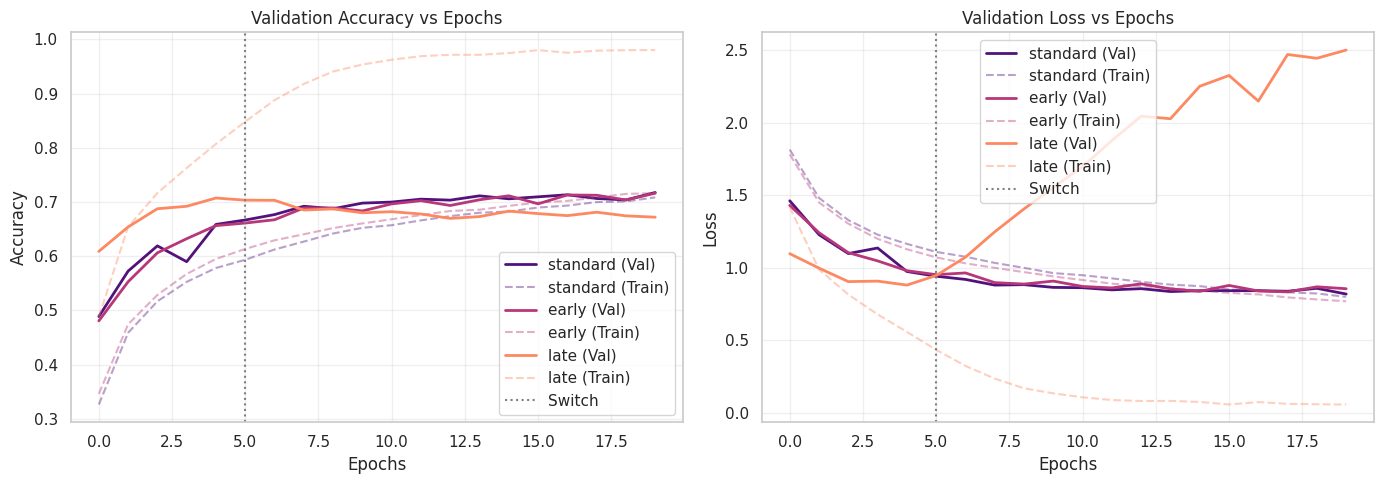

In [ ]:
# 1. Graphe 1: Courbes d'apprentissage superposées
exp.compare_learning_curves(
    modes=["standard", "early", "late"], switch_epoch=5, rate=0.3, epochs=20
)



📊 Comparing Dropout Rates Impact on Accuracy
   Running standard with rate=0.1...
   Running early with rate=0.1...
   Running late with rate=0.1...
   Running standard with rate=0.2...
   Running early with rate=0.2...
   Running late with rate=0.2...
   Running standard with rate=0.3...
   Running early with rate=0.3...
   Running late with rate=0.3...
   Running standard with rate=0.4...
   Running early with rate=0.4...
   Running late with rate=0.4...
   Running standard with rate=0.5...
   Running early with rate=0.5...
   Running late with rate=0.5...


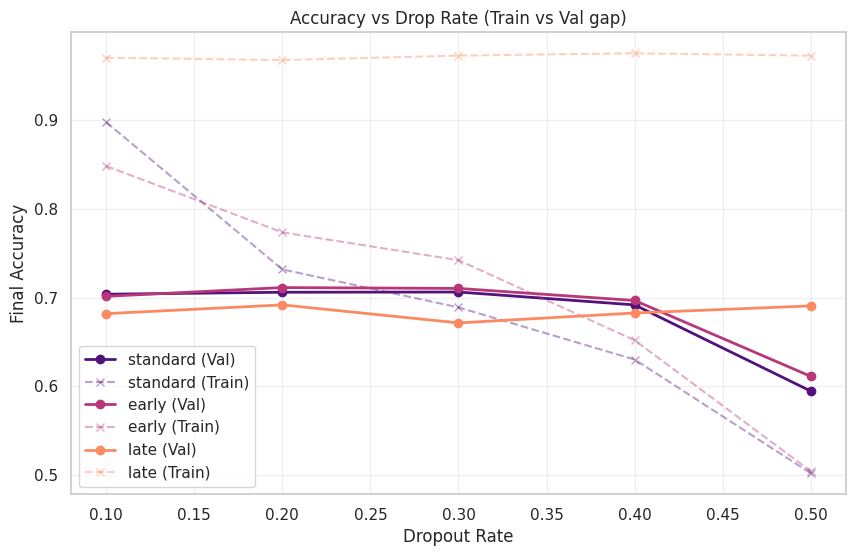

In [21]:
# 2. Graphe 2: Accuracy vs Drop Rate
exp.compare_drop_rates(
    rates=[0.1, 0.3, 0.5],
    modes=["standard", "early", "late"],
    epochs=15,
    switch_epoch=5,
)


📊 Comparing Switch Epochs Impact on Accuracy
   Running early with switch_epoch=2...
   Running standard with switch_epoch=2...
   Running early with switch_epoch=5...
   Running standard with switch_epoch=5...
   Running early with switch_epoch=10...
   Running standard with switch_epoch=10...
   Running early with switch_epoch=15...
   Running standard with switch_epoch=15...


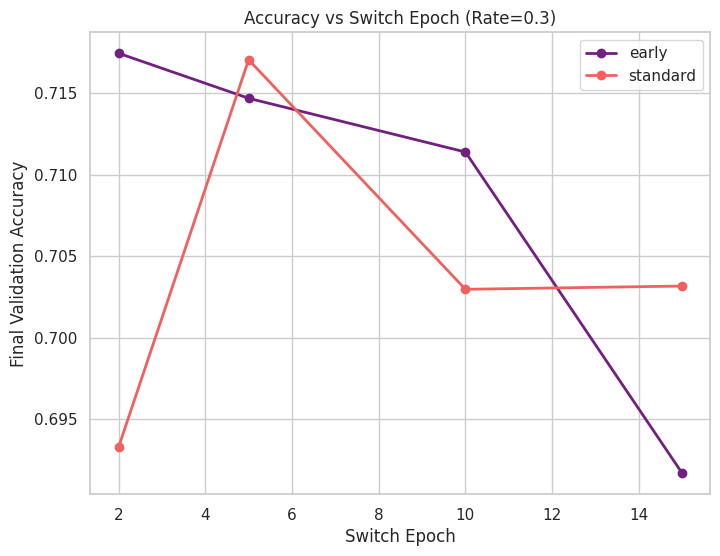

In [15]:
# 3. Graphe 3: Accuracy vs Epoch Switch
exp.compare_switch_epochs(
    switch_epochs=[2, 5, 10, 15],
    modes=["early", "standard"],
    epochs=15,
    rate=0.3,
)
